In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from os.path import join
%matplotlib inline
import seaborn as sns
from PSPupil import dataset as dt

from scipy.stats import ttest_ind, linregress, f_oneway#, tukey_hsd
from decim.adjuvant import slurm_submit as slu
import itertools



def smaller_than(value):
    logs=np.append(np.logspace(-15, 1, 17), .05)
    sorteds=np.sort(np.append(logs, value))
    index=np.where(sorteds==value)[0]
    return sorteds[index+1][0]

def p_annot(p_value):
    if p_value < 0.01:
        text = 'p <{0}'.format(smaller_than(p_value))
    else:
        text = 'p= %.2f' % p_value
    
    if p_value<0.05:
        bold = 'bold'
    else: 
        bold = 'normal'
    return text, bold
        

def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c

def permutation_cluster_test(x1, x2):
    f, clusters, pvalues, h0=mne.stats.permutation_cluster_test([x1,x2],
                                                                     threshold=dict(start=0, step=0.2))
    return pvalues

def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)


def show_p_statistic(yticks):
    ylim = yticks[1] + 2/5 * (yticks[1] - yticks[0])
    first=4/5 * (ylim - yticks[1]) + yticks[1]
    third=2/5 * (ylim - yticks[1]) + yticks[1]
    offset=(first-yticks[0])/25
    return ylim, first, third, offset


edition = '/Volumes/psp_data/PSP/Pupil_Preprocessed_2024-06-17/'
slu.mkdir_p(join(edition, 'PowerFrequencies'))
slu.mkdir_p(join(edition, 'Figures'))


### Script version with 'Pupil_Preprocessed_2024-06-17'
- i.e. fooof included, no z-scoring

In [2]:
#Plotting parameters
palette = sns.color_palette("Paired")

'''
baseline_color = palette[4]
followup_color = palette[5]
ips_color = palette[0]
control_color = palette[2]
r = rgb_to_hex(196, 98, 74)
ips_color = rgb_to_hex(123, 118, 19)
control_color = rgb_to_hex(228, 193, 91)
baseline_color = '#F0746E'
follow_color = baseline_color
ips_color = '#7CCBA2'
control_color = '#FCDE9C'
'''



colorcycler=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]
linecycler=["-", "--", "-.", ":", "-", "--", "-."]


baseline_color = 'tab:red'
follow_color = baseline_color
ips_color = 'tab:purple'
control_color = 'tab:orange'

sns.set(style='ticks')
sns.set(style='ticks',font='HelveticaNeue', font_scale=1, rc={
    'axes.labelsize': 6,
    'axes.titlesize': 6,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 6,
    'axes.linewidth': .5,
    'xtick.major.width': .5,
    'ytick.major.width': .5,
        'xtick.minor.width': .5,
    'ytick.minor.width': .5,
    'ytick.major.pad': 0,
    'ytick.minor.pad': 1.0,
    'xtick.major.pad': 1.0,
    'xtick.minor.pad': 1.0,
    'axes.labelpad': 0,
    "xtick.major.size":2,
    "xtick.minor.size":1,
    "ytick.major.size":2,
    "ytick.minor.size":1
})


psize=4
line_width_p = .4
scatter_marker = 16
scatter_alpha=.5

line_width_b = .5

lw_power1 = 1.5
lw_power = 1

In [3]:
pd_fpower_avg = pd.read_hdf(join(edition, 'Figures', 'data', 'pd_fpower_avg.hdf'), 
                            key = 'data')

In [4]:

psp_baseline_avg = pd.read_hdf(join(edition, 'Figures', 'data', 'psp_baseline_avg.hdf'), 
                           key = 'data') 

In [5]:
psp_baseline_avg

,session,0.0,0.016666666666666666,0.03333333333333333,0.05,0.06666666666666667,0.08333333333333333,0.1,0.11666666666666667,0.13333333333333333,...,29.849999999999998,29.866666666666667,29.883333333333333,29.9,29.916666666666668,29.933333333333334,29.95,29.966666666666665,29.983333333333334,30.0
subject,,,,,,,,,,,,,,,,,,,,,
001,Baseline,8.155730,31.896984,18.054232,10.284923,5.281923,2.994811,2.612909,2.619602,2.297459,...,5.356312e-22,4.741661e-22,4.199328e-22,3.729347e-22,3.331693e-22,3.006352e-22,2.753312e-22,2.572560e-22,2.464158e-22,1.214002e-22
002,Baseline,1.565330,8.559536,10.014237,8.465854,3.703855,2.139609,1.705264,1.386715,1.859266,...,5.501369e-22,5.329152e-22,5.177201e-22,5.045535e-22,4.934101e-22,4.842963e-22,4.772061e-22,4.721432e-22,4.691025e-22,2.340456e-22
003,Baseline,1.076389,8.777261,8.636251,5.048564,3.762805,3.434076,3.505998,2.774821,1.793126,...,2.461813e-21,2.432571e-21,2.406771e-21,2.384413e-21,2.365494e-21,2.350016e-21,2.337981e-21,2.329383e-21,2.324222e-21,1.161250e-21
006,Baseline,2.863395,19.311482,19.492997,12.396654,9.309146,4.848874,4.731967,3.603700,3.985710,...,1.274103e-21,1.218228e-21,1.168938e-21,1.126219e-21,1.090076e-21,1.060503e-21,1.037505e-21,1.021071e-21,1.011217e-21,5.039680e-22
007,Baseline,4.183499,19.948456,12.465134,10.226755,5.315025,3.251340,3.434296,3.417139,2.718448,...,6.614513e-22,6.512718e-22,6.422873e-22,6.345017e-22,6.279121e-22,6.225252e-22,6.183335e-22,6.153377e-22,6.135389e-22,3.064708e-22
009,Baseline,24.324000,65.519414,49.747278,38.682729,23.167626,23.311494,19.666967,15.887306,14.488103,...,7.412825e-21,7.197746e-21,7.007995e-21,6.843562e-21,6.704411e-21,6.590572e-21,6.502033e-21,6.438799e-21,6.400844e-21,3.194102e-21
010,Baseline,5.624202,27.360938,19.909568,7.717337,6.454444,6.643700,5.803434,5.312064,6.780013,...,3.512258e-21,3.409835e-21,3.319491e-21,3.241188e-21,3.174930e-21,3.120726e-21,3.078572e-21,3.048470e-21,3.030389e-21,1.512185e-21
012,Baseline,2.890659,16.975338,16.105781,18.188331,19.838963,11.818142,10.477969,7.710600,6.071263,...,1.376675e-21,1.321244e-21,1.272339e-21,1.229951e-21,1.194095e-21,1.164751e-21,1.141933e-21,1.125630e-21,1.115859e-21,5.562956e-22
013,Baseline,15.021058,87.899165,61.977565,40.379935,29.098890,14.362951,15.744678,17.227807,15.808990,...,4.119017e-21,4.017800e-21,3.928484e-21,3.851083e-21,3.785590e-21,3.732009e-21,3.690348e-21,3.660575e-21,3.642710e-21,1.818381e-21


## 1. Power Spectra ALl groups main (Fig 1A)

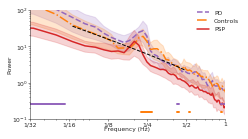

In [143]:
# data for plotting: 
popt = np.load(join(edition, 'Figures', 'data', 'popt.npy')) 
auc_x = np.load(join(edition, 'Figures', 'data', 'auc_x.npy')) 
pvals_psp_pd = np.load(join(edition, 'Figures', 'data', 'pvals_psp_pd.npy'))
pvals_psp_c = np.load(join(edition, 'Figures', 'data', 'pvals_psp_c.npy')) 
permut_x = np.load(join(edition, 'Figures', 'data', 'permut_x.npy')) 


psp_baseline_avg = pd.read_hdf(join(edition, 'Figures', 'data', 'psp_baseline_avg.hdf'), 
                           key = 'data') 
pd_fpower_avg = pd.read_hdf(join(edition, 'Figures', 'data', 'pd_fpower_avg.hdf'), 
                            key = 'data') 
ctrl_fpower_avg = pd.read_hdf(join(edition, 'Figures', 'data', 'ctrl_fpower_avg.hdf'), 
                              key = 'data') 

f, ax = plt.subplots(figsize=(3.5, 2))
f.suptitle('')
ci=95


stacked = pd_fpower_avg.drop(['session'], axis=1).unstack().reset_index()
plot = sns.lineplot(data= stacked, x='level_0', y=0, ci=ci, color=ips_color, lw=0, label=None, alpha=1, dashes=[(2,2)])
plt.plot(stacked.groupby('level_0').mean().index, stacked.groupby('level_0').mean().values, label='PD', linewidth=lw_power1, color = ips_color, linestyle=linecycler[1])


stacked = ctrl_fpower_avg.drop(['session'], axis=1).unstack().reset_index()
plot = sns.lineplot(data= stacked, x='level_0', y=0, ci=ci, color=control_color, lw=0, label=None, alpha=1, dashes=linecycler[2])
plt.plot(stacked.groupby('level_0').mean().index, stacked.groupby('level_0').mean().values, label='Controls', linewidth=lw_power1, color = control_color, linestyle=linecycler[2])


stacked = psp_baseline_avg.drop(['session'], axis=1).unstack().reset_index()
plot = sns.lineplot(data= stacked, x='level_0', y=0, ci=ci, color=baseline_color, lw=0, label=None, alpha=1, dashes=linecycler[0])
plt.plot(stacked.groupby('level_0').mean().index, stacked.groupby('level_0').mean().values, label='PSP', linewidth=lw_power1, color = baseline_color, linestyle=linecycler[0])


plot.set(xscale='log', yscale='log')
plot.set(xlim = (1/32, 1), ylim=(.1, 100))
ax.set(xlabel='Frequency (Hz)',
      ylabel='Power',
      xticks=[1/32,1/16, 1/8, 1/4, 1/2, 1],
      xticklabels=['1/32','1/16', '1/8', '1/4', '1/2', '1'])
sns.despine()
plt.plot(auc_x, func_powerlaw(auc_x, *popt), color='black', linestyle='--', lw=lw_power)



#plt cluster permutation test results
a=.15
cluster_distance = np.diff(permut_x).mean()/2
for i in permut_x[pvals_psp_c<0.05]:
    plt.plot([i-cluster_distance, i+cluster_distance], [a, a], color=control_color, lw=2)

a = .25
for i in permut_x[pvals_psp_pd<0.05]:
    plt.plot([i-cluster_distance, i+cluster_distance], [a, a], color=ips_color, lw=2)
    

#plt.scatter(permut_x[pvals_psp_pd<0.05],  np.repeat(.15, len(permut_x[pvals_psp_pd<0.05]), axis=None), color='black', marker='*')

#plt.scatter(permut_x[pvals_psp_c<0.05].values, .05, color='grey', marker='*')
#plt.scatter(permut_x[pvals_pd_cont<0.05].values, .05, color='lightgrey', marker='*')



ax.legend(bbox_to_anchor=(1.1, 1.05), frameon=False)

#f.tight_layout()
f.savefig(join(edition, 'Figures', 'PowerSpectra_all_groups.png'), dpi=600)


## 2.1 Deprecated:AUC/CoV/F/Offset no FOOV (FIG 1B OLD)

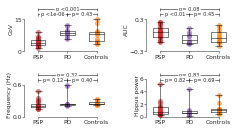

In [64]:
## data
df = pd.read_hdf(join(edition, 'Figures', 'data', 'CoV.hdf'), key='data')
psp_baseline_auc = pd.read_hdf(join(edition, 'Figures', 'data', 'psp_baseline_auc.hdf'), key='data')
pd_auc = pd.read_hdf(join(edition, 'Figures', 'data', 'pd_auc.hdf'), key='data')
ctrl_auc = pd.read_hdf(join(edition, 'Figures', 'data', 'ctrl_auc.hdf'), key='data')
hip = pd.read_hdf(join(edition, 'Figures', 'data', 'hip.hdf'), key= 'data')
hip_limit = .9

f, ax = plt.subplots(2, 2, figsize = (3.5, 2))

#baseline_color='darkgrey'
#ips_color = 'darkgrey'
#control_color='darkgrey'

# Top LEFT - COV



yticks = [0, 15]
ylim, first, third, offset = show_p_statistic(yticks)


p = df.loc[(df.group == 'PSP')&(df.session == 'Baseline')].CoV.values
i= df.loc[df.group == 'PD'].CoV.values
c= df.loc[df.group == 'Controls'].CoV.values

ax[0,0].scatter(np.zeros(p.shape), p, color=baseline_color, s = scatter_marker, alpha = scatter_alpha)
ax[0,0].scatter(np.ones(i.shape), i, color=ips_color, s = scatter_marker, alpha = scatter_alpha)
ax[0,0].scatter(2*np.ones(c.shape), c, color=control_color, s = scatter_marker, alpha = scatter_alpha)

ax[0,0].boxplot(p, positions=[0], widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
           medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

ax[0,0].boxplot(i, positions=[1], widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
           medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

ax[0,0].boxplot(c, positions=[2], widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
           medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

ax[0,0].set(xlabel='',
      xticks=[0,1, 2],
      xticklabels=['PSP',
                  'PD', 'Controls'],
      ylabel='CoV',
     ylim=[yticks[0], ylim],
      yticks=yticks)

ax[0,0].vlines(0, ymin=first-offset, ymax=first+offset, lw=line_width_p)
ax[0,0].vlines(2, ymin=first-offset, ymax=first+offset, lw=line_width_p)
ax[0,0].plot((0, 2), (first, first), color='black', lw=line_width_p)
ax[0,0].annotate(p_annot(ttest_ind(p,c)[1])[0], weight = p_annot(ttest_ind(c,i)[1])[1],
                 xy=(1,first), fontsize=psize, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=1))

ax[0,0].vlines(0, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[0,0].vlines(1, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[0,0].plot((0, 1), (third, third), color='black', lw=line_width_p)
ax[0,0].annotate(p_annot(ttest_ind(p,i)[1])[0], weight = p_annot(ttest_ind(c,i)[1])[1], xy=(.5,third), fontsize=psize, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=1))

ax[0,0].vlines(1, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[0,0].vlines(2, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[0,0].plot((1, 2), (third, third), color='black', lw=line_width_p)
ax[0,0].annotate(p_annot(ttest_ind(c,i)[1])[0], weight = p_annot(ttest_ind(c,i)[1])[1], 
                 xy=(1.5,third), fontsize=psize, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=1))



# TOP RIGHT - AUC



p = psp_baseline_auc.auc.values
i=pd_auc.auc.values
c = ctrl_auc.auc.values

yticks = [-.3, .3]
ylim, first, third, offset = show_p_statistic(yticks)

ax[0,1].scatter(np.zeros(p.shape), p, color=baseline_color, label='PSP', s=scatter_marker, alpha = scatter_alpha)
ax[0,1].scatter(np.ones(i.shape), i, color=ips_color, label = 'PD', s=scatter_marker, alpha = scatter_alpha)
ax[0,1].scatter(np.ones(c.shape)*2, c, color=control_color, label = 'CTRL', s=scatter_marker, alpha = scatter_alpha)

ax[0,1].boxplot(p, positions=[0], widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
           medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

ax[0,1].boxplot(i, positions=[1], widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
           medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

ax[0,1].boxplot(c, positions=[2], widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
           medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

ax[0,1].set(xlabel='',
      xticks=[0,1, 2],
      xticklabels=['PSP',
                  'PD',
                  'Controls'],
      ylabel='AUC',
       ylim=[yticks[0], ylim],
      yticks=yticks)


ax[0,1].vlines(0, ymin=first-offset, ymax=first+offset, lw=line_width_p)
ax[0,1].vlines(2, ymin=first-offset, ymax=first+offset, lw=line_width_p)
ax[0,1].plot((0, 2), (first, first), color='black', lw=line_width_p)
ax[0,1].annotate(p_annot(ttest_ind(p,c)[1])[0], weight = p_annot(ttest_ind(c,i)[1])[1], xy=(1,first), fontsize=psize, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=1))

ax[0,1].vlines(0, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[0,1].vlines(1, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[0,1].plot((0, 1), (third, third), color='black', lw=line_width_p)
ax[0,1].annotate(p_annot(ttest_ind(p,i)[1])[0], weight = p_annot(ttest_ind(c,i)[1])[1], xy=(.5,third), fontsize=psize, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=1))

ax[0,1].vlines(1, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[0,1].vlines(2, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[0,1].plot((1, 2), (third, third), color='black', lw=line_width_p)
ax[0,1].annotate(p_annot(ttest_ind(c,i)[1])[0], weight = p_annot(ttest_ind(c,i)[1])[1], xy=(1.5,third), fontsize=psize, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=1))



#BOTTOM LEFT - FREQUENCY

df = hip.loc[hip.frequency<hip_limit]
p = df.loc[df.group == 'baseline'].frequency.values
i = df.loc[df.group == 'ips'].frequency.values
c = df.loc[df.group == 'control'].frequency.values

yticks = [0, .6]
ylim, first, third, offset = show_p_statistic(yticks)



ax[1,0].scatter(np.zeros(p.shape), p, color=baseline_color, label='PSP', s=scatter_marker, alpha = scatter_alpha)
ax[1,0].scatter(np.ones(i.shape), i, color=ips_color, label = 'PD', s=scatter_marker, alpha = scatter_alpha)
ax[1,0].scatter(np.ones(c.shape)*2, c, color=control_color, label = 'CTRL', s=scatter_marker, alpha = scatter_alpha)


ax[1,0].boxplot(p, positions=[0],widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
           medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

ax[1,0].boxplot(i, positions=[1], widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
           medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

ax[1,0].boxplot(c, positions=[2], widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
           medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

ax[1,0].set(xlabel='',
      xticks=[0,1, 2],
      xticklabels=['PSP', 'PD',
                  'Controls'],
      ylabel='Frequency (Hz)',
       ylim=[yticks[0], ylim],
      yticks=yticks)

ax[1,0].vlines(0, ymin=first-offset, ymax=first+offset, lw=line_width_p)
ax[1,0].vlines(2, ymin=first-offset, ymax=first+offset, lw=line_width_p)
ax[1,0].plot((0, 2), (first, first), color='black', lw=line_width_p)
ax[1,0].annotate(p_annot(ttest_ind(p,c)[1])[0], weight = p_annot(ttest_ind(c,i)[1])[1], xy=(1,first), fontsize=psize, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=1))

ax[1,0].vlines(0, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[1,0].vlines(1, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[1,0].plot((0, 1), (third, third), color='black', lw=line_width_p)
ax[1,0].annotate(p_annot(ttest_ind(p,i)[1])[0], weight = p_annot(ttest_ind(c,i)[1])[1], xy=(.5,third), fontsize=psize, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=1))

ax[1,0].vlines(1, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[1,0].vlines(2, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[1,0].plot((1, 2), (third, third), color='black', lw=line_width_p)
ax[1,0].annotate(p_annot(ttest_ind(c,i)[1])[0], weight = p_annot(ttest_ind(c,i)[1])[1], xy=(1.5,third), fontsize=psize, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=1))



#BOTTOM RIGHT - MAGNITUDE

yticks = [0, 5]
ylim, first, third, offset = show_p_statistic(yticks)

df = hip.loc[hip.frequency<hip_limit].drop('hippus_power', axis=1)
df = df.dropna()
p = df.loc[df.group == 'baseline'].offset.values
i = df.loc[df.group == 'ips'].offset.values
c = df.loc[df.group == 'control'].offset.values


ax[1,1].scatter(np.zeros(p.shape), p, color=baseline_color, label='PSP', s=scatter_marker, alpha = scatter_alpha)
ax[1,1].scatter(np.ones(i.shape), i, color=ips_color, label = 'PD', s=scatter_marker, alpha = scatter_alpha)
ax[1,1].scatter(np.ones(c.shape)*2, c, color=control_color, label = 'CTRL', s=scatter_marker, alpha = scatter_alpha)


ax[1,1].boxplot(p, positions=[0], widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
           medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

ax[1,1].boxplot(i, positions=[1], widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
           medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

ax[1,1].boxplot(c, positions=[2], widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
           medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

ax[1,1].set(xlabel='',
      xticks=[0,1, 2],
      xticklabels=['PSP', 'PD',
                  'Controls'],
      ylabel='''Hippus power''',
       ylim=[yticks[0], ylim],
      yticks=[0, 2, 4, 6])



ax[1,1].vlines(0, ymin=first-offset, ymax=first+offset, lw=line_width_p)
ax[1,1].vlines(2, ymin=first-offset, ymax=first+offset, lw=line_width_p)
ax[1,1].plot((0, 2), (first, first), color='black', lw=line_width_p)
ax[1,1].annotate(p_annot(ttest_ind(p,c)[1])[0], weight = p_annot(ttest_ind(c,i)[1])[1], xy=(1,first), fontsize=psize, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=1))

ax[1,1].vlines(0, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[1,1].vlines(1, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[1,1].plot((0, 1), (third, third), color='black', lw=line_width_p)
ax[1,1].annotate(p_annot(ttest_ind(p,i)[1])[0], weight = p_annot(ttest_ind(c,i)[1])[1], xy=(.5,third), fontsize=psize, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=1))


ax[1,1].vlines(1, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[1,1].vlines(2, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[1,1].plot((1, 2), (third, third), color='black', lw=line_width_p)
ax[1,1].annotate(p_annot(ttest_ind(c,i)[1])[0], weight = p_annot(ttest_ind(c,i)[1])[1], xy=(1.5,third), fontsize=psize, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=1))



sns.despine(trim=True)
f.tight_layout()


f.savefig(join(edition, 'Figures', 'Pupil_metrics_all_groups.png'),  dpi=600)


## 2.2 NEW Pupil Metrics (incl FOOOF) -> Fig 1D 

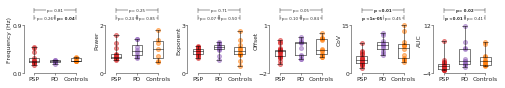

In [142]:
## load data
CoV = pd.read_hdf(join(edition, 'PowerFrequencies', 'CoV.hdf'), key='data')
CoV.loc[:, 'CoV'] = CoV.loc[:, 'std'] / CoV.loc[:, 'mean'] *100
auc = pd.read_hdf(join(edition, 'PowerFrequencies', 'auc_bp_non_normalized.hdf'), key='data')
psp_baseline_auc = auc.loc[(auc.group == 'PSP')&(auc.session == 'Baseline')]
pd_auc = auc.loc[(auc.group == 'PD')&(auc.session == 'Baseline')]
ctrl_auc = auc.loc[(auc.group == 'Control')&(auc.session == 'Baseline')]
fooov = pd.read_hdf(join(edition, 'SPECPARAMS', 'Specparams_2024-06-18.hdf'), key= 'data')

### Exclude PD subject 12
CoV = CoV.set_index(['group', 'subject']).drop(('PD', '12')).reset_index()
fooov = fooov.set_index(['group', 'subject']).drop(('PD', '12')).reset_index()
pd_auc = pd_auc.set_index(['group', 'subject']).drop(('PD', '12')).reset_index()


def subplot(j, ylabel, yticks, data):
    ylim, first, third, offset = show_p_statistic(yticks)
    p=data[0]
    i=data[1]
    c=data[2]


    ax[j].scatter(np.zeros(p.shape), p, color=baseline_color, label='PSP', s=scatter_marker, alpha = scatter_alpha)
    ax[j].scatter(np.ones(i.shape), i, color=ips_color, label = 'PD', s=scatter_marker, alpha = scatter_alpha)
    ax[j].scatter(np.ones(c.shape)*2, c, color=control_color, label = 'CTRL', s=scatter_marker, alpha = scatter_alpha)


    ax[j].boxplot(p, positions=[0],widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
               medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

    ax[j].boxplot(i, positions=[1], widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
               medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

    ax[j].boxplot(c, positions=[2], widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
               medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

    ax[j].set(xlabel='',
          xticks=[0,1, 2],
          xticklabels=['PSP', 'PD',
                      'Controls'],
          ylabel=ylabel,
           ylim=[yticks[0], ylim],
          yticks=yticks)

    ax[j].vlines(0, ymin=first-offset, ymax=first+offset, lw=line_width_p)
    ax[j].vlines(2, ymin=first-offset, ymax=first+offset, lw=line_width_p)
    ax[j].plot((0, 2), (first, first), color='black', lw=line_width_p)
    ax[j].annotate(p_annot(ttest_ind(p,c)[1])[0], weight = p_annot(ttest_ind(p,c)[1])[1], xy=(1,first), fontsize=psize, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=1))

    ax[j].vlines(0, ymin=third-offset, ymax=third+offset, lw=line_width_p)
    ax[j].vlines(1, ymin=third-offset, ymax=third+offset, lw=line_width_p)
    ax[j].plot((0, 1), (third, third), color='black', lw=line_width_p)
    ax[j].annotate(p_annot(ttest_ind(p,i)[1])[0], weight = p_annot(ttest_ind(p,i)[1])[1], xy=(.5,third), fontsize=psize, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=1))

    ax[j].vlines(1, ymin=third-offset, ymax=third+offset, lw=line_width_p)
    ax[j].vlines(2, ymin=third-offset, ymax=third+offset, lw=line_width_p)
    ax[j].plot((1, 2), (third, third), color='black', lw=line_width_p)
    ax[j].annotate(p_annot(ttest_ind(c,i)[1])[0], weight = p_annot(ttest_ind(c,i)[1])[1], xy=(1.5,third), fontsize=psize, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=1))

    


f, ax = plt.subplots(1, 6, figsize = (7, 1.2))

# 1. Frequency
df = fooov.loc[(fooov.session == 'Baseline')&(~fooov.peak1_CF.isnull())]
p = df.loc[df.group == 'PSP'].peak1_CF.values
i = df.loc[df.group == 'PD'].peak1_CF.values
c = df.loc[df.group == 'Control'].peak1_CF.values
subplot(j=0, yticks=[0, 0.9], ylabel = 'Frequency (Hz)', data = [p, i, c])

# 2. power
df = fooov.loc[(fooov.session == 'Baseline')&(~fooov.peak1_CF.isnull())]
p = df.loc[df.group == 'PSP'].peak1_PW.values
i = df.loc[df.group == 'PD'].peak1_PW.values
c = df.loc[df.group == 'Control'].peak1_PW.values
subplot(j=1, yticks=[0, 2], ylabel = 'Power', data = [p, i, c])

# 3. Exponent
df = fooov.loc[(fooov.session == 'Baseline')]
p = df.loc[df.group == 'PSP'].aperiodic_exp.values
i = df.loc[df.group == 'PD'].aperiodic_exp.values
c = df.loc[df.group == 'Control'].aperiodic_exp.values
subplot(j=2, yticks=[0, 3], ylabel = 'Exponent', data = [p, i, c])

# 3. Offset
df = fooov.loc[(fooov.session == 'Baseline')]
p = df.loc[df.group == 'PSP'].aperiodic_offset.values
i = df.loc[df.group == 'PD'].aperiodic_offset.values
c = df.loc[df.group == 'Control'].aperiodic_offset.values
subplot(j=3, yticks=[-2, 1], ylabel = 'Offset', data = [p, i, c])


# 5. CoV
CoV = CoV.loc[CoV.condition == 'bp_non_normalized'].groupby(['group', 'subject', 'session']).mean().reset_index()
p = CoV.loc[(CoV.group == 'PSP')&(CoV.session == 'Baseline')&(CoV.session == 'Baseline')].CoV.values
i= CoV.loc[CoV.group == 'PD'].CoV.values
c= CoV.loc[CoV.group == 'Control'].CoV.values
subplot(j=4, yticks=[0, 15], ylabel = 'CoV', data = [p, i, c])


# 6. AUC
p = psp_baseline_auc.auc.values
i=pd_auc.auc.values
c = ctrl_auc.auc.values
subplot(j=5, yticks=[-4, 12], ylabel = 'AUC', data = [p, i, c])


sns.despine(trim=True)
f.tight_layout(pad=.5, w_pad=0)

f.savefig(join(edition, 'Figures', 'Pupil_metrics_all_groups_fooov.png'),  dpi=600)

## 3. Follow-up vs. Baseline
### 3.1 Spectra

['001' '003' '006' '007' '010' '012' '016' '018' '019' '020']


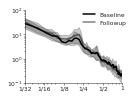

In [116]:
#data
psp_followup_avg = pd.read_hdf(join(edition, 'Figures', 'data', 'psp_followup_avg.hdf'), key='data')
subjects = np.intersect1d(psp_followup_avg.index, psp_baseline_avg.index)

print(subjects)

baseline_color='black'
follow_color='grey'

f, ax = plt.subplots(figsize=(1/2*3.5, 2/3*2))
ci=95

stacked = psp_baseline_avg.loc[subjects].drop(['session'], axis=1).unstack().reset_index()
plot = sns.lineplot(data= stacked, x='level_0', y=0, ci=ci, color=baseline_color, lw=lw_power1, label='Baseline')

stacked = psp_followup_avg.loc[subjects].drop(['session'], axis=1).unstack().reset_index()
plot = sns.lineplot(data= stacked, x='level_0', y=0, ci=ci, color=baseline_color, alpha=.5, lw=lw_power1, label='Followup')

plot.set(xscale='log', yscale='log')
plot.set(xlim = (1/32, 1), ylim=(.1, 100))
ax.set(xlabel='',
      ylabel='',
      xticks=[1/32,1/16, 1/8, 1/4, 1/2, 1],
      xticklabels=['1/32','1/16', '1/8', '1/4', '1/2', '1'])
sns.despine()

# plt.plot(auc_x, func_powerlaw(auc_x, *popt), color='black', linestyle='--', lw=lw_power)
# plt.plot(permut_x, ((pvals<.05)+1)*.02, color='black')

ax.legend(bbox_to_anchor=(1.1, 1.05), frameon=False)

#f.tight_layout()
f.savefig(join(edition, 'Figures', 'PowerSpectra_FU.png'), dpi=600)






### 3.2 Deprecated: Metrics (No FOOOV)

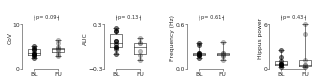

In [67]:
# Metrics FU vs. BL - OLD
psp_followup_auc = pd.read_hdf(join(edition, 'Figures', 'data', 'psp_followup_auc.hdf'), key='data')
hip = pd.read_hdf(join(edition, 'Figures', 'data', 'hip.hdf'), key= 'data')
hip_limit = .9
CoV = pd.read_hdf(join(edition, 'Figures', 'data', 'CoV.hdf'), key='data')
subjects = np.load(join(edition, 'Figures', 'data', 'subjects.npy'), allow_pickle=True)



f, ax = plt.subplots(1, 4, figsize = (4/3*3.5, 2/3*2))


# COV

## data
df = pd.read_hdf(join(edition, 'Figures', 'data', 'CoV.hdf'), key='data')
bl = CoV.loc[(CoV.group == 'PSP')&(CoV.session == 'Baseline')&CoV.subject.isin(subjects)].CoV.values
fl = CoV.loc[(CoV.group == 'PSP')&(CoV.session == 'Followup')&CoV.subject.isin(subjects)].CoV.values

yticks = [0, 10]
ylim, first, third, offset = show_p_statistic(yticks)


ax[0].scatter(np.zeros(bl.shape), bl, color=baseline_color, s = scatter_marker, alpha = scatter_alpha)
ax[0].scatter(np.ones(fl.shape), fl, color=follow_color, s = scatter_marker, alpha = scatter_alpha)

ax[0].boxplot(bl, positions=[0], widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
           medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

ax[0].boxplot(fl, positions=[1], widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
           medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))


ax[0].set(xlabel='',
      xticks=[0,1, 2],
      xticklabels=['BL', 'FU'],
      ylabel='CoV',
     ylim=[yticks[0], ylim],
      yticks=yticks)


ax[0].vlines(0, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[0].vlines(1, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[0].plot((0, 1), (third, third), color='black', lw=line_width_p)
ax[0].annotate(p_annot(ttest_ind(bl,fl)[1])[0], weight = p_annot(ttest_ind(bl, fl)[1])[1], xy=(.5,third), fontsize=psize, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=1))




# AUC

# load data 
bl = psp_baseline_auc.loc[psp_baseline_auc.subject.isin(subjects)].auc.values
fl=psp_followup_auc.loc[psp_baseline_auc.subject.isin(subjects)].auc.values

yticks = [-.3, .3]
ylim, first, third, offset = show_p_statistic(yticks)

ax[1].scatter(np.zeros(bl.shape), bl, color=baseline_color, label='PSP', s=scatter_marker, alpha = scatter_alpha)
ax[1].scatter(np.ones(fl.shape), fl, color=follow_color, label = 'PD', s=scatter_marker, alpha = scatter_alpha)

ax[1].boxplot(bl, positions=[0], widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
           medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

ax[1].boxplot(fl, positions=[1], widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
           medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

ax[1].set(xlabel='',
      xticks=[0,1, 2],
      xticklabels=['BL', 'FU'],
      ylabel='AUC',
       ylim=[yticks[0], ylim],
      yticks=yticks)

ax[1].vlines(0, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[1].vlines(1, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[1].plot((0, 1), (third, third), color='black', lw=line_width_p)
ax[1].annotate(p_annot(ttest_ind(bl,fl)[1])[0], weight = p_annot(ttest_ind(bl, fl)[1])[1], xy=(.5,third), fontsize=psize, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=1))



#third FREQUENCY

# load data
df = hip.loc[hip.frequency<hip_limit]

bl = df.loc[(df.group == 'baseline')&(df.subject.isin(subjects))].frequency.values
fl = df.loc[(df.group == 'followup')&(df.subject.isin(subjects))].frequency.values


yticks = [0, .6]
ylim, first, third, offset = show_p_statistic(yticks)



ax[2].scatter(np.zeros(bl.shape), bl, color=baseline_color, label='PSP', s=scatter_marker, alpha = scatter_alpha)
ax[2].scatter(np.ones(fl.shape), fl, color=follow_color, label = 'PD', s=scatter_marker, alpha = scatter_alpha)


ax[2].boxplot(bl, positions=[0],widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
           medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

ax[2].boxplot(fl, positions=[1], widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
           medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

ax[2].set(xlabel='',
      xticks=[0,1, 2],
      xticklabels=['BL', 'FU'],
      ylabel='Frequency (Hz)',
       ylim=[yticks[0], ylim],
      yticks=yticks)

ax[2].vlines(0, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[2].vlines(1, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[2].plot((0, 1), (third, third), color='black', lw=line_width_p)
ax[2].annotate(p_annot(ttest_ind(bl, fl)[1])[0], weight = p_annot(ttest_ind(bl, fl)[1])[1], xy=(.5,third), fontsize=psize, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=1))

#BOTTOM RIGHT - MAGNITUDE
# load data
df = hip.loc[hip.frequency<hip_limit]

bl = df.loc[(df.group == 'baseline')&(df.subject.isin(subjects))].offset.values
fl = df.loc[(df.group == 'followup')&(df.subject.isin(subjects))].offset.values


yticks = [0, 6]
ylim, first, third, offset = show_p_statistic(yticks)



ax[3].scatter(np.zeros(bl.shape), bl, color=baseline_color, label='PSP', s=scatter_marker, alpha = scatter_alpha)
ax[3].scatter(np.ones(fl.shape), fl, color=follow_color, label = 'PD', s=scatter_marker, alpha = scatter_alpha)


ax[3].boxplot(bl, positions=[0],widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
           medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

ax[3].boxplot(fl, positions=[1], widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
           medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

ax[3].set(xlabel='',
      xticks=[0,1, 2],
      xticklabels=['BL', 'FU'],
      ylabel='Hippus power',
       ylim=[yticks[0], ylim],
      yticks=yticks)

ax[3].vlines(0, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[3].vlines(1, ymin=third-offset, ymax=third+offset, lw=line_width_p)
ax[3].plot((0, 1), (third, third), color='black', lw=line_width_p)
ax[3].annotate(p_annot(ttest_ind(bl, fl)[1])[0], weight = p_annot(ttest_ind(bl, fl)[1])[1], xy=(.5,third), fontsize=psize, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=1))

sns.despine(trim=True)
f.tight_layout()


f.savefig(join(edition, 'Figures', 'Pupil_metrics_followup.png'),  dpi=600)

### 3.3 NEW: Metrics incl. FOOOV

In [153]:
# Function for subplots
def subplot_2(j, ylabel, yticks, data, xticklabels=['BL', 'FU'], print_p=False):
    bl = data[0]
    fl = data [1]
    ylim, first, third, offset = show_p_statistic(yticks)
    ax[j].scatter(np.zeros(bl.shape), bl, color=baseline_color, label='PSP', s=scatter_marker, alpha = scatter_alpha)
    ax[j].scatter(np.ones(fl.shape), fl, color=follow_color, label = 'PD', s=scatter_marker, alpha = scatter_alpha)


    ax[j].boxplot(bl, positions=[0],widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
               medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

    ax[j].boxplot(fl, positions=[1], widths=.5, boxprops = dict(linewidth=line_width_b), whiskerprops = dict(linewidth=line_width_b), capprops = dict(linewidth=line_width_b),
               medianprops = dict(linestyle='-', linewidth=line_width_b, color='black'), showfliers=False, whis=(0, 100))

    ax[j].set(xlabel='',
          xticks=[0,1, 2],
          xticklabels=xticklabels,
          ylabel=ylabel,
           ylim=[yticks[0], ylim],
          yticks=yticks)
    ax[j].vlines(0, ymin=third-offset, ymax=third+offset, lw=line_width_p)
    ax[j].vlines(1, ymin=third-offset, ymax=third+offset, lw=line_width_p)
    ax[j].plot((0, 1), (third, third), color='black', lw=line_width_p)
    ttest = ttest_ind(bl, fl)
    if print_p is True:
        print(ylabel, ttest)
    ax[j].annotate(p_annot(ttest[1])[0], weight = p_annot(ttest[1])[1], xy=(.5,third), fontsize=psize, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=1))


Frequency (Hz) Ttest_indResult(statistic=-0.3439037965785674, pvalue=0.7351356097258778)
Power Ttest_indResult(statistic=-0.41897826161951807, pvalue=0.6804780893451514)
Exponent Ttest_indResult(statistic=-1.3275814522776899, pvalue=0.1950392557493963)
Offset Ttest_indResult(statistic=0.3774859045147473, pvalue=0.7086588148947457)
CoV Ttest_indResult(statistic=-2.0187830262491757, pvalue=0.05866018906192159)
AUC Ttest_indResult(statistic=-0.848346081082181, pvalue=0.40738572299366227)


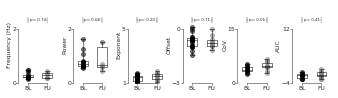

In [155]:
# Metrics FU vs. BL with FOOOV
## data
CoV = pd.read_hdf(join(edition, 'PowerFrequencies', 'CoV.hdf'), key='data')
CoV.loc[:, 'CoV'] = CoV.loc[:, 'std'] / CoV.loc[:, 'mean'] *100
CoV = CoV.loc[CoV.condition == 'bp_non_normalized'].groupby(['group', 'subject', 'session']).mean().reset_index()
auc = pd.read_hdf(join(edition, 'PowerFrequencies', 'auc_bp_non_normalized.hdf'), key='data')
psp_baseline_auc = auc.loc[(auc.group == 'PSP')&(auc.session == 'Baseline')]
psp_followup_auc = auc.loc[(auc.group == 'PSP')&(auc.session == 'Followup')]
fooov = pd.read_hdf(join(edition, 'SPECPARAMS', 'Specparams_2024-06-18.hdf'), key= 'data')

baseline_color='black'
follow_color='grey'


f, ax = plt.subplots(1, 6, figsize = (4/3*3.5, 2/3*2))
    
# 1. Frequency
bl =  fooov.loc[(fooov.session == 'Baseline')&(~fooov.peak1_CF.isnull())&(fooov.group == 'PSP')].peak1_CF.values
fl =  fooov.loc[(fooov.session == 'Followup')&(~fooov.peak1_CF.isnull())&(fooov.group == 'PSP')].peak1_CF.values
subplot_2(j=0, yticks=[0, 2], ylabel = 'Frequency (Hz)', data = [bl, fl], print_p=True)

# 2. power
bl =  fooov.loc[(fooov.session == 'Baseline')&(~fooov.peak1_CF.isnull())&(fooov.group == 'PSP')].peak1_PW.values
fl =  fooov.loc[(fooov.session == 'Followup')&(~fooov.peak1_CF.isnull())&(fooov.group == 'PSP')].peak1_PW.values
subplot_2(j=1, yticks=[0, 2], ylabel = 'Power', data = [bl, fl], print_p=True)


# 3. Exponent
bl =  fooov.loc[(fooov.session == 'Baseline')&(fooov.group == 'PSP')].aperiodic_exp.values
fl =  fooov.loc[(fooov.session == 'Followup')&(fooov.group == 'PSP')].aperiodic_exp.values
subplot_2(j=2, yticks=[1, 5], ylabel = 'Exponent', data = [bl, fl], print_p=True)


# 3. Offset
bl =  fooov.loc[(fooov.session == 'Baseline')&(fooov.group == 'PSP')].aperiodic_offset.values
fl =  fooov.loc[(fooov.session == 'Followup')&(fooov.group == 'PSP')].aperiodic_offset.values
subplot_2(j=3, yticks=[-3, 0], ylabel = 'Offset', data = [bl, fl], print_p=True)


# 5. CoV
bl = CoV.loc[(CoV.group == 'PSP')&(CoV.session == 'Baseline')&CoV.subject.isin(subjects)].CoV.values
fl = CoV.loc[(CoV.group == 'PSP')&(CoV.session == 'Followup')&CoV.subject.isin(subjects)].CoV.values
subplot_2(j=4, yticks=[0, 15], ylabel = 'CoV', data = [bl, fl], print_p=True)


# 6. AUC
bl = psp_baseline_auc.loc[psp_baseline_auc.subject.isin(subjects)].auc.values
fl=psp_followup_auc.loc[psp_followup_auc.subject.isin(subjects)].auc.values
subplot_2(j=5, yticks=[-4, 12], ylabel = 'AUC', data = [bl, fl], print_p=True)


sns.despine(trim=True)
f.tight_layout(pad=.5, w_pad=0)
    
    
f.savefig(join(edition, 'Figures', 'Pupil_metrics_followup_fooov.png'),  dpi=600)

### 3.4 NEW Metrics Follow-up reduced

17.4
14.559999999999999


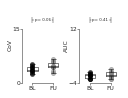

In [146]:
# Metrics FU vs. BL with FOOOV
## data
CoV = pd.read_hdf(join(edition, 'PowerFrequencies', 'CoV.hdf'), key='data')
CoV.loc[:, 'CoV'] = CoV.loc[:, 'std'] / CoV.loc[:, 'mean'] *100
CoV = CoV.loc[CoV.condition == 'bp_non_normalized'].groupby(['group', 'subject', 'session']).mean().reset_index()
auc = pd.read_hdf(join(edition, 'PowerFrequencies', 'auc_bp_non_normalized.hdf'), key='data')
psp_baseline_auc = auc.loc[(auc.group == 'PSP')&(auc.session == 'Baseline')]
psp_followup_auc = auc.loc[(auc.group == 'PSP')&(auc.session == 'Followup')]
fooov = pd.read_hdf(join(edition, 'SPECPARAMS', 'Specparams_2024-06-18.hdf'), key= 'data')

baseline_color='black'
follow_color='grey'
f, ax = plt.subplots(1, 2, figsize = (3/6*3.5, 2/3*2))
    

# 5. CoV
bl = CoV.loc[(CoV.group == 'PSP')&(CoV.session == 'Baseline')&CoV.subject.isin(subjects)].CoV.values
fl = CoV.loc[(CoV.group == 'PSP')&(CoV.session == 'Followup')&CoV.subject.isin(subjects)].CoV.values
subplot_2(j=0, yticks=[0, 15], ylabel = 'CoV', data = [bl, fl])


# 6. AUC
bl = psp_baseline_auc.loc[psp_baseline_auc.subject.isin(subjects)].auc.values
fl=psp_followup_auc.loc[psp_followup_auc.subject.isin(subjects)].auc.values
subplot_2(j=1, yticks=[-4, 12], ylabel = 'AUC', data = [bl, fl])


sns.despine(trim=True)
f.tight_layout(pad=.5, w_pad=0)
    
    
f.savefig(join(edition, 'Figures', 'Pupil_metrics_followup_fooov_reduced.png'),  dpi=600)

## 4. PSP-RS vs. non-RS
### 4.1 Spectra

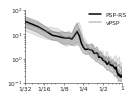

In [117]:
#data
# data for plotting: 
popt = np.load(join(edition, 'Figures', 'data', 'popt.npy')) 
auc_x = np.load(join(edition, 'Figures', 'data', 'auc_x.npy')) 
psp_baseline_avg = pd.read_hdf(join(edition, 'Figures', 'data', 'psp_baseline_avg.hdf'), 
                           key = 'data') 

f, ax = plt.subplots(figsize=(1/2*3.5, 2/3*2))

baseline_color='black'
follow_color='grey'

ci=95

stacked = psp_baseline_avg.loc[dt.RS].drop(['session'], axis=1).unstack().reset_index()
plot = sns.lineplot(data= stacked, x='level_0', y=0, ci=ci, color=baseline_color, lw=lw_power1, label='PSP-RS')

stacked = psp_baseline_avg.loc[dt.non_RS].drop(['session'], axis=1).unstack().reset_index()
plot = sns.lineplot(data= stacked, x='level_0', y=0, ci=ci, color=follow_color, alpha=.5, lw=lw_power1, label='vPSP')

plot.set(xscale='log', yscale='log')
plot.set(xlim = (1/32, 1), ylim=(.1, 100))
ax.set(xlabel='',
      ylabel='',
      xticks=[1/32,1/16, 1/8, 1/4, 1/2, 1],
      xticklabels=['1/32','1/16', '1/8', '1/4', '1/2', '1'])
sns.despine()

# plt.plot(auc_x, func_powerlaw(auc_x, *popt), color='black', linestyle='--', lw=lw_power)
# plt.plot(permut_x, ((pvals<.05)+1)*.02, color='black')

ax.legend(bbox_to_anchor=(1.1, 1.05), frameon=False)

#f.tight_layout()
f.savefig(join(edition, 'Figures', 'PowerSpectra_RS.png'), dpi=600)



### 4.2 Deprecated: Metrics RS (No FOOOV)
- non fooov

11.6
0.396
0.696
6.96


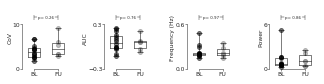

In [34]:
### auxiliary

# load data
hip = pd.read_hdf(join(edition, 'Figures', 'data', 'hip.hdf'), key= 'data')
hip_limit = .9
CoV = pd.read_hdf(join(edition, 'Figures', 'data', 'CoV.hdf'), key='data')
psp_baseline_auc = pd.read_hdf(join(edition, 'Figures', 'data', 'psp_baseline_auc.hdf'), key='data')



f, ax = plt.subplots(1, 4, figsize = (4/3*3.5, 2/3*2))


# COV
bl = CoV.loc[(CoV.group == 'PSP')&(CoV.session == 'Baseline')&CoV.subject.isin(dt.RS)].CoV.values
fl = CoV.loc[(CoV.group == 'PSP')&(CoV.session == 'Baseline')&CoV.subject.isin(dt.non_RS)].CoV.values
subplot(j=0, yticks = [0, 10], ylabel = 'CoV', data = [bl, fl], xticklabels=['PSP-RS', 'vPSP'])


# AUC
bl = psp_baseline_auc.loc[psp_baseline_auc.subject.isin(dt.RS)].auc.values
fl=psp_baseline_auc.loc[psp_baseline_auc.subject.isin(dt.non_RS)].auc.values
subplot(j=1, yticks = [-.3, .3], ylabel = 'AUC', data = [bl, fl], xticklabels=['PSP-RS', 'vPSP'])


#FREQUENCY

# load data
df = hip.loc[hip.frequency<hip_limit]
bl = df.loc[(df.group == 'baseline')&(df.subject.isin(dt.RS))].frequency.values
fl = df.loc[(df.group == 'baseline')&(df.subject.isin(dt.non_RS))].frequency.values
subplot(j=2, yticks = [0, .6], ylabel = 'Frequency (Hz)', data = [bl, fl], xticklabels=['PSP-RS', 'vPSP'])


#Power
df = hip.loc[hip.frequency<hip_limit]
bl = df.loc[(df.group == 'baseline')&(df.subject.isin(dt.RS))].offset.values
fl = df.loc[(df.group == 'baseline')&(df.subject.isin(dt.non_RS))].offset.values
subplot(j=3, yticks = [0, 6], ylabel = 'Power', data = [bl, fl], xticklabels=['PSP-RS', 'vPSP'])


sns.despine(trim=True)
f.tight_layout()


#f.savefig(join(edition, 'Figures', 'Pupil_metrics_RS.png'),  dpi=600)

### 4.3 NEW Metrics RS incl FOOOV 
- fooov
- full

Frequency (Hz) Ttest_indResult(statistic=0.146334874661349, pvalue=0.8865649673464965)
Power Ttest_indResult(statistic=-0.983134268790163, pvalue=0.3487291701747983)
Exponent Ttest_indResult(statistic=2.037204831506413, pvalue=0.056607894606113075)
Offset Ttest_indResult(statistic=-1.9063436959044793, pvalue=0.07269976901202119)
CoV Ttest_indResult(statistic=-1.3106995398180563, pvalue=0.20643698014554965)
AUC Ttest_indResult(statistic=-0.4802564250612039, pvalue=0.636829713959207)


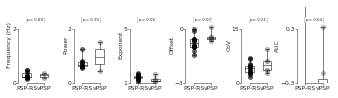

In [156]:
# Metrics FU vs. BL with FOOOV
## data
CoV = pd.read_hdf(join(edition, 'PowerFrequencies', 'CoV.hdf'), key='data')
CoV.loc[:, 'CoV'] = CoV.loc[:, 'std'] / CoV.loc[:, 'mean'] *100
CoV = CoV.loc[CoV.condition == 'bp_non_normalized'].groupby(['group', 'subject', 'session']).mean().reset_index()
auc = pd.read_hdf(join(edition, 'PowerFrequencies', 'auc_bp_non_normalized.hdf'), key='data')
psp_baseline_auc = auc.loc[(auc.group == 'PSP')&(auc.session == 'Baseline')]
psp_followup_auc = auc.loc[(auc.group == 'PSP')&(auc.session == 'Followup')]
fooov = pd.read_hdf(join(edition, 'SPECPARAMS', 'Specparams_2024-06-18.hdf'), key= 'data')

baseline_color='black'
follow_color='grey'



f, ax = plt.subplots(1, 6, figsize = (4/3*3.5, 2/3*2))
    
# 1. Frequency
bl =  fooov.loc[(fooov.session == 'Baseline')&(~fooov.peak1_CF.isnull())&(fooov.group == 'PSP')&(fooov.subject.isin(dt.RS))].peak1_CF.values
fl =  fooov.loc[(fooov.session == 'Followup')&(~fooov.peak1_CF.isnull())&(fooov.group == 'PSP')&(fooov.subject.isin(dt.non_RS))].peak1_CF.values
subplot_2(j=0, yticks=[0, 2], ylabel = 'Frequency (Hz)', data = [bl, fl], xticklabels=['PSP-RS', 'vPSP'], print_p=True)

# 2. power
bl =  fooov.loc[(fooov.session == 'Baseline')&(~fooov.peak1_CF.isnull())&(fooov.group == 'PSP')&(fooov.subject.isin(dt.RS))].peak1_PW.values
fl =  fooov.loc[(fooov.session == 'Followup')&(~fooov.peak1_CF.isnull())&(fooov.group == 'PSP')&(fooov.subject.isin(dt.non_RS))].peak1_PW.values
subplot_2(j=1, yticks=[0, 2], ylabel = 'Power', data = [bl, fl], xticklabels=['PSP-RS', 'vPSP'], print_p=True)


# 3. Exponent
bl =  fooov.loc[(fooov.session == 'Baseline')&(fooov.group == 'PSP')&(fooov.subject.isin(dt.RS))].aperiodic_exp.values
fl =  fooov.loc[(fooov.session == 'Baseline')&(fooov.group == 'PSP')&(fooov.subject.isin(dt.non_RS))].aperiodic_exp.values
subplot_2(j=2, yticks=[1, 5], ylabel = 'Exponent', data = [bl, fl], xticklabels=['PSP-RS', 'vPSP'], print_p=True)


# 3. Offset
bl =  fooov.loc[(fooov.session == 'Baseline')&(fooov.group == 'PSP')&(fooov.subject.isin(dt.RS))].aperiodic_offset.values
fl =  fooov.loc[(fooov.session == 'Baseline')&(fooov.group == 'PSP')&(fooov.subject.isin(dt.non_RS))].aperiodic_offset.values
subplot_2(j=3, yticks=[-3, 0], ylabel = 'Offset', data = [bl, fl], xticklabels=['PSP-RS', 'vPSP'], print_p=True)


# 5. CoV
bl = CoV.loc[(CoV.group == 'PSP')&(CoV.session == 'Baseline')&(CoV.subject.isin(dt.RS))].CoV.values
fl = CoV.loc[(CoV.group == 'PSP')&(CoV.session == 'Baseline')&(CoV.subject.isin(dt.non_RS))].CoV.values
subplot_2(j=4, yticks=[0, 15], ylabel = 'CoV', data = [bl, fl], xticklabels=['PSP-RS', 'vPSP'], print_p=True)


# 6. AUC
bl = psp_baseline_auc.loc[psp_baseline_auc.subject.isin(dt.RS)].auc.values
fl=psp_baseline_auc.loc[psp_baseline_auc.subject.isin(dt.non_RS)].auc.values
subplot_2(j=5, yticks=[-.3, .3], ylabel = 'AUC', data = [bl, fl], xticklabels=['PSP-RS', 'vPSP'], print_p=True)


sns.despine(trim=True)
f.tight_layout(pad=.5, w_pad=0)
    
    
f.savefig(join(edition, 'Figures', 'Pupil_metrics_RS_fooov.png'),  dpi=600)

### 4.4 NEW Metrics RS FOOOV reduced

17.4
14.559999999999999


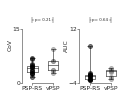

In [124]:
# Metrics FU vs. BL with FOOOV
CoV = pd.read_hdf(join(edition, 'PowerFrequencies', 'CoV.hdf'), key='data')
CoV.loc[:, 'CoV'] = CoV.loc[:, 'std'] / CoV.loc[:, 'mean'] *100
CoV = CoV.loc[CoV.condition == 'bp_non_normalized'].groupby(['group', 'subject', 'session']).mean().reset_index()
auc = pd.read_hdf(join(edition, 'PowerFrequencies', 'auc_bp_non_normalized.hdf'), key='data')
psp_baseline_auc = auc.loc[(auc.group == 'PSP')&(auc.session == 'Baseline')]

baseline_color='black'
follow_color='grey'

f, ax = plt.subplots(1, 2, figsize = (1/2*3.5, 2/3*2))

# 5. CoV
bl = CoV.loc[(CoV.group == 'PSP')&(CoV.session == 'Baseline')&(CoV.subject.isin(dt.RS))].CoV.values
fl = CoV.loc[(CoV.group == 'PSP')&(CoV.session == 'Baseline')&(CoV.subject.isin(dt.non_RS))].CoV.values
subplot_2(j=0, yticks=[0, 15], ylabel = 'CoV', data = [bl, fl], xticklabels=['PSP-RS', 'vPSP'])

# 6. AUC
bl = psp_baseline_auc.loc[psp_baseline_auc.subject.isin(dt.RS)].auc.values
fl=psp_baseline_auc.loc[psp_baseline_auc.subject.isin(dt.non_RS)].auc.values
subplot_2(j=1, yticks=[-4, 12], ylabel = 'AUC', data = [bl, fl], xticklabels=['PSP-RS', 'vPSP'])

sns.despine(trim=True)
f.tight_layout(pad=.5, w_pad=0)
    
f.savefig(join(edition, 'Figures', 'Pupil_metrics_RS_fooov_reduced.png'),  dpi=600)

## 5. Modeling examples

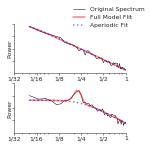

In [48]:
no_hippus = pd.read_hdf(join(edition, 'PowerFrequencies', 'Example_model_fit_HC07_no_hippus.hdf'), key='data')
hippus = pd.read_hdf(join(edition, 'PowerFrequencies', 'Example_model_fit_HC08_hippus.hdf'), key='data')

f, ax = plt.subplots(2, 1, figsize=(2, 2))


ax[0].plot(no_hippus.freqs.values, no_hippus.power_spectrum.values, color= 'black', lw=lw_power1-1, alpha=1, label = 'Original Spectrum')
ax[0].plot(no_hippus.freqs.values, no_hippus.modeled_spectrum_.values, color= 'red', alpha=.5, lw=lw_power1, label = 'Full Model FIit')
ax[0].plot(no_hippus.freqs.values, no_hippus._ap_fit.values, color= 'blue', linestyle='dotted', alpha=.5, lw=lw_power1, label = 'Aperiodic Fit')

ax[0].set(xscale='log')
ax[0].set(xlim = (1/32, 1), ylim=(-3, 1))
ax[0].set(xlabel='',
      ylabel='Power',
      xticks=[1/32,1/16, 1/8, 1/4, 1/2, 1],
      xticklabels=['1/32','1/16', '1/8', '1/4', '1/2', '1'],
      yticks=[-2, -1, 0, 1],
         yticklabels=[])

ax[1].plot(hippus.freqs.values, hippus.power_spectrum.values, color= 'black', lw=lw_power1-1, alpha=1,)
ax[1].plot(hippus.freqs.values, hippus.modeled_spectrum_.values, color= 'red', alpha=.5, lw=lw_power1)
ax[1].plot(hippus.freqs.values, hippus._ap_fit.values, color= 'blue', linestyle='dotted', alpha=.5, lw=lw_power1)

ax[1].set(xscale='log')
ax[1].set(xlim = (1/32, 1), ylim=(-3, 1))
ax[1].set(xlabel='',
      ylabel='Power',
      xticks=[1/32,1/16, 1/8, 1/4, 1/2, 1],
      xticklabels=['1/32','1/16', '1/8', '1/4', '1/2', '1'],
      yticks=[-2, -1, 0, 1],
         yticklabels=[])




sns.despine()
f.legend(bbox_to_anchor=(1.04, 1.02), frameon=False)
#f.tight_layout()

f.savefig(join(edition, 'Figures', 'Example_model_no_hippus.png'),  dpi=600)

## 6. Bar plot

In [6]:
params = pd.read_hdf(join(edition, 'SPECPARAMS', 'Specparams_2024-06-18.hdf'), key= 'data')

### Exclude PD sub 12
params = params.set_index(['group', 'subject']).drop(('PD', '12')).reset_index()

In [134]:
print('PSP: {0} with at least 1 peak, {1} with no detected peak'.format(params.loc[(params.session == 'Baseline')&(~params.peak1_CF.isnull())].groupby('group').count().loc['PSP'].session,
                                                                       params.loc[(params.session == 'Baseline')&(params.peak1_CF.isnull())].groupby('group').count().loc['PSP'].session))

print('PD: {0} with at least 1 peak, {1} with no detected peak'.format(params.loc[(params.session == 'Baseline')&(~params.peak1_CF.isnull())].groupby('group').count().loc['PD'].session,
                                                                       params.loc[(params.session == 'Baseline')&(params.peak1_CF.isnull())].groupby('group').count().loc['PD'].session))

print('HC: {0} with at least 1 peak, {1} with no detected peak'.format(params.loc[(params.session == 'Baseline')&(~params.peak1_CF.isnull())].groupby('group').count().loc['Control'].session,
                                                                       params.loc[(params.session == 'Baseline')&(params.peak1_CF.isnull())].groupby('group').count().loc['Control'].session))


PSP: 13 with at least 1 peak, 7 with no detected peak
PD: 8 with at least 1 peak, 3 with no detected peak
HC: 7 with at least 1 peak, 5 with no detected peak


Hippus
No hippus


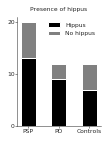

In [135]:
groups = (
    "PSP",
    "PD",
    "Controls",
)
weight_counts = {
    "Hippus": np.array([13,9,7]),
    "No hippus": np.array([7,3,5])
}

textures = {"Hippus": ['x', 'black'],
    "No hippus": ['', 'grey']}

width = 0.5

fig, ax = plt.subplots(figsize=(1.5, 2))
bottom = np.zeros(3)




for boolean, weight_count in weight_counts.items():
    print(boolean)
    p = ax.bar(groups, weight_count, width, label=boolean, bottom=bottom, color=textures[boolean][1])
    bottom += weight_count

ax.set_title("Presence of hippus")
ax.legend(loc="upper right", frameon=False)

ax.set(yticks=[0, 10, 20])

sns.despine()
fig.savefig(join(edition, 'Figures', 'hippus_presence.png'),  dpi=600)

In [7]:
params

,group,subject,session,aperiodic_offset,aperiodic_knee,aperiodic_exp,n_peaks,peak1_CF,peak1_PW,peak1_BW,peak2_CF,peak2_PW,peak2_BW,peak3_CF,peak3_PW,peak3_BW,R2,error
0,Control,02,Baseline,0.198992,0.740525,0.740525,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.809913,0.111873
1,Control,03,Baseline,-0.489661,2.049690,2.049690,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.965898,0.119258
2,Control,04,Baseline,-0.573680,1.421185,1.421185,1,0.287169,0.507475,0.150000,NaN,NaN,NaN,NaN,NaN,NaN,0.954832,0.104344
3,Control,05,Baseline,-0.620154,1.515128,1.515128,1,0.232556,1.399931,0.050000,NaN,NaN,NaN,NaN,NaN,NaN,0.961479,0.110773
4,Control,06,Baseline,0.229873,1.166603,1.166603,1,0.289837,0.712373,0.150000,NaN,NaN,NaN,NaN,NaN,NaN,0.942433,0.103571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,PSP_Molly,041,Baseline,-1.207984,1.156969,1.156969,1,0.212939,0.473364,0.150000,NaN,NaN,NaN,NaN,NaN,NaN,0.930275,0.116958
81,PSP_Molly,042,Baseline,-1.017044,1.613430,1.613430,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.945572,0.115495
82,PSP_Molly,045,Baseline,-0.661646,1.366996,1.366996,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.888920,0.156389
83,PSP_Molly,046,Baseline,-1.717595,1.358906,1.358906,1,0.185216,1.134489,0.089279,NaN,NaN,NaN,NaN,NaN,NaN,0.941033,0.133117


In [13]:
params.loc[(params.group == 'Control')&(params.session== 'Baseline')].shape

(12, 18)